In [1]:
# Show the correlation between real and predicted tuning curves
import os
parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
grandparent_directory = os.path.abspath(os.path.join(parent_directory, os.pardir))
os.sys.path.append(grandparent_directory)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from scipy.stats import pearsonr

from tools.data_formatting import get_smoothed_moving_all_data, get_common_indexes_n_recordings, smooth_tuning_curves_circularly, from_local_to_global_index
from tools.data_manager import get_all_experiments_runs, get_fovs_given_animal
from tools.alignment import procrustes, canoncorr
from params import order_experiments, get_colors_for_each_experiment, animals, root_dir, experiments_to_exclude

# Load the data

In [2]:
### Load all sessions ###

animal = 'm135'
fov = 'fov1'
sessions = get_all_experiments_runs(animal, fov)
# Remove sessions to exclude
sessions = [session for session in sessions if session not in experiments_to_exclude]
# Create a mapping of sessions and their chronological order
order_map = {value: index for index, value in enumerate(order_experiments)}
sessions = sorted(sessions, key=lambda x: order_map[x])

# Load the cells with the global index and the tuning curves
all_cells = []
all_tuning_curves = []
for (experiment, run) in sessions:
    _, _, phi, cells, tuning_curves, _ = get_smoothed_moving_all_data(animal, fov, experiment, run)
    cells = from_local_to_global_index(animal, fov, (experiment, run), cells)
    all_cells.append(cells)
    all_tuning_curves.append(tuning_curves)

# Using the first session as the 'predictor' to look at the profiles of tuning curves in the neural space of all the other sessions. 

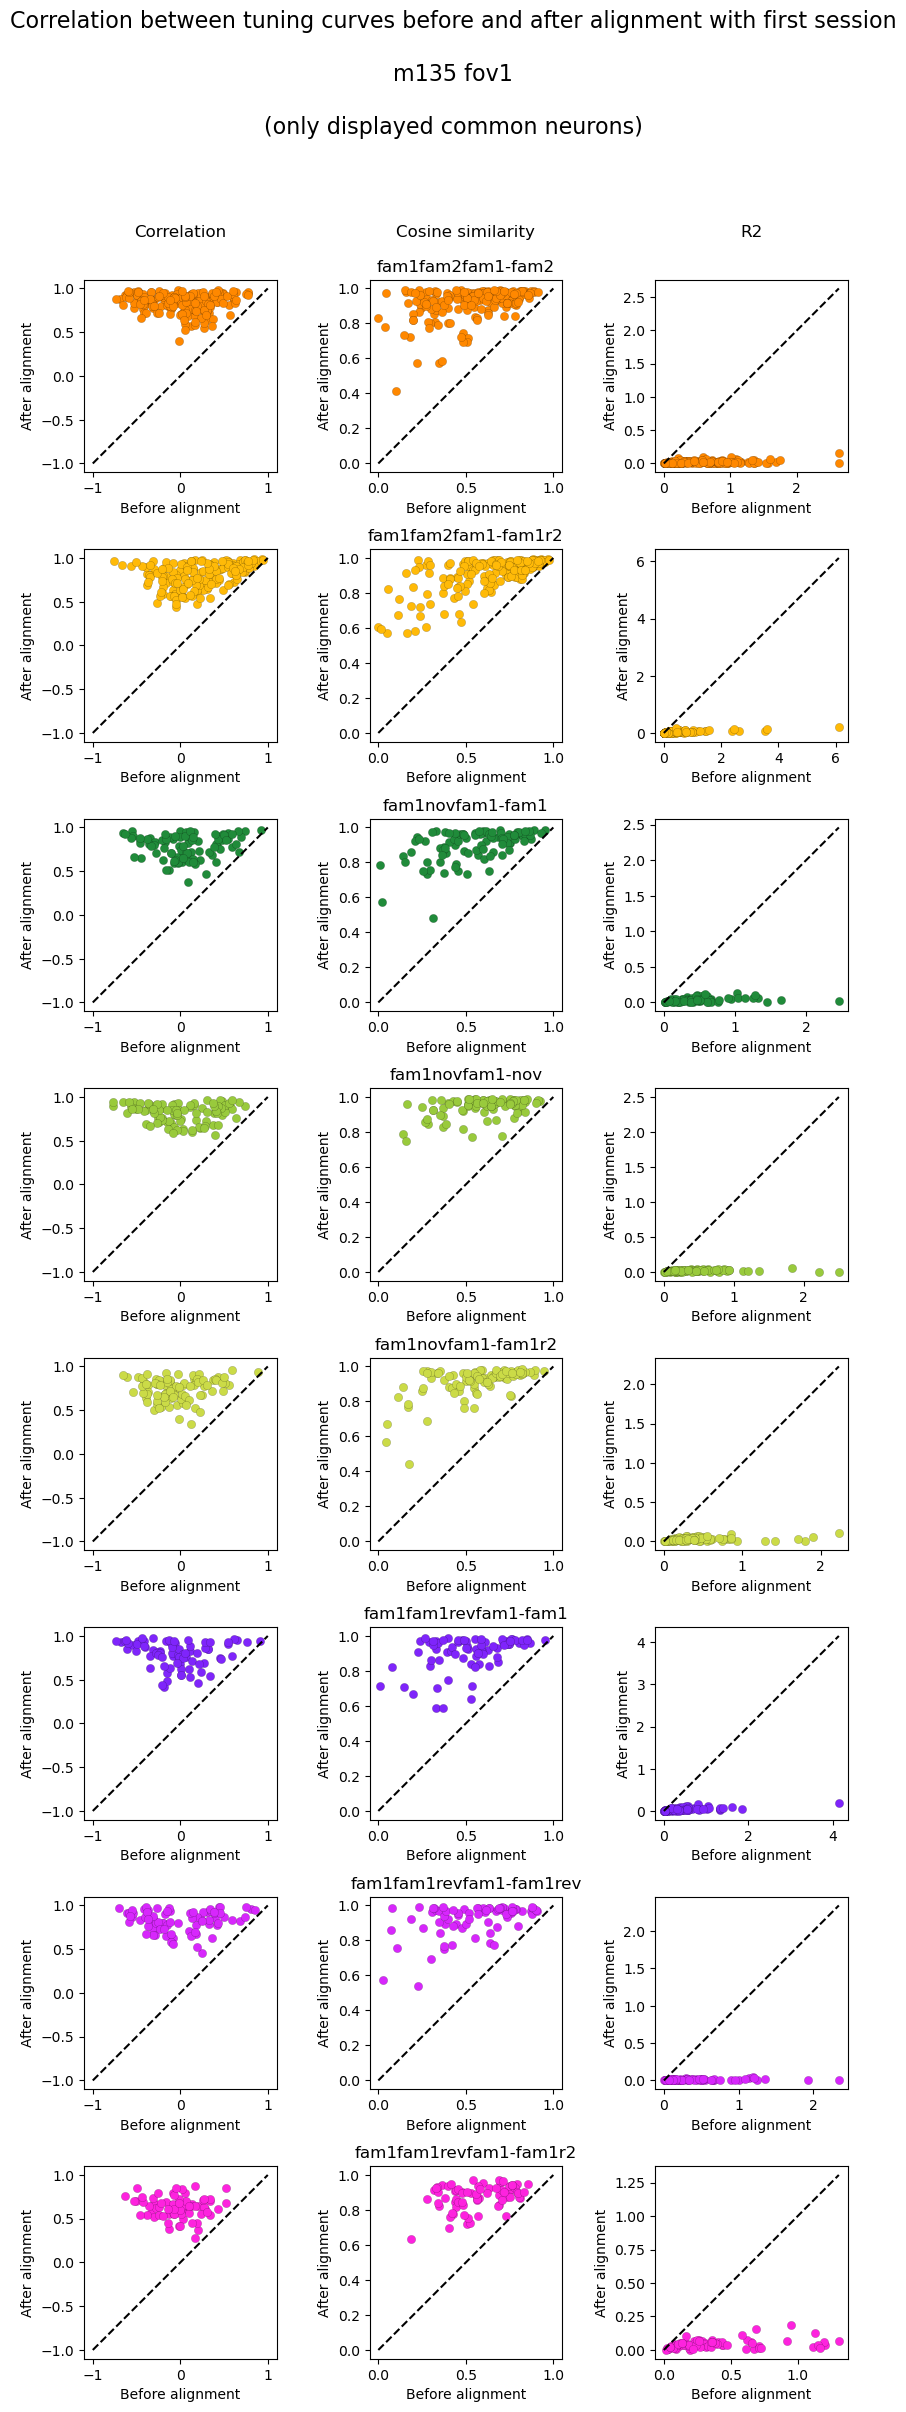

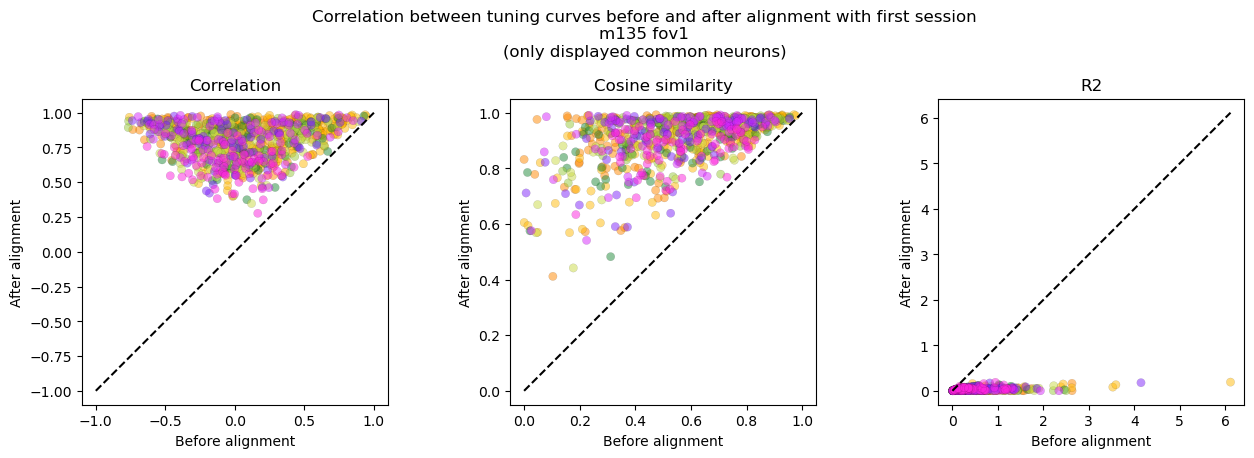

In [3]:
### Align the tuning curves to a reference session ###

# Smooth the tuning curves very little for better alignment
smoothed_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, 5) for tuning_curves in all_tuning_curves]
# Take the first session as the reference
ref = 0
exp0, run0 = sessions[ref]
ref_avg_fr = smoothed_tuning_curves[ref]
ref_cells = all_cells[ref]
# Find its embedding
pca = PCA(n_components=20) # Use 20 as it is around 80% of the variance
pca_ref_tc = pca.fit_transform(ref_avg_fr)
# Transform all the other tuning curves to the reference
predicted_tuning_curves = [] # ref session onto the other session
ref_tuning_curves = [] # ref session
real_tuning_curves = [] # other session
for i in range(len(sessions)-1):
    # Get the session to align to
    tuning_curves = smoothed_tuning_curves[i+1]
    # Get common neurons with reference session
    cells_masks, ordered_cells, common_neurons = get_common_indexes_n_recordings([ref_cells, all_cells[i+1]])
    # Align the tuning curves
    pca_tc = pca.fit_transform(tuning_curves)
    pca_components = pca.components_
    pca_means = np.mean(tuning_curves, axis=0)
    _, B, _, ref_cca_tc, _ = canoncorr(pca_ref_tc, pca_tc, fullReturn=True)
    # Calculate the predicted tuning curves
    predicted_tc = (ref_cca_tc @ np.linalg.inv(B) @ pca_components) + pca_means
    # Only keep the neurons that are common to both sessions
    real_tc = tuning_curves[:, cells_masks[1]]
    real_tc = real_tc[:, ordered_cells[1]]
    predicted_tc = predicted_tc[:, cells_masks[1]]
    predicted_tc = predicted_tc[:, ordered_cells[1]]
    ref_tc = ref_avg_fr[:, cells_masks[0]]
    ref_tc = ref_tc[:, ordered_cells[0]]
    real_tuning_curves.append(real_tc)
    predicted_tuning_curves.append(predicted_tc)
    ref_tuning_curves.append(ref_tc)


### Plot the correlation, cosine similarity, R2 between real and predicted tuning curves ###

fig = plt.figure(figsize=(10, 3*len(sessions)))
fig.suptitle(f'Correlation between tuning curves before and after alignment with first session\n\n{animal} {fov}\n\n(only displayed common neurons)', fontsize=16)
grid = plt.GridSpec(nrows=len(sessions)-1, ncols=3, figure=fig, wspace=0.4, hspace=0.4)
colors = get_colors_for_each_experiment(sessions[1:])
for i, (exp, run) in enumerate(sessions[1:]):
    # Where to save the metrics for this session
    correlations_aligned, correlations_not_aligned = [], []
    cosine_similarities_aligned, cosine_similarities_not_aligned = [], []
    r2_aligned, r2_not_aligned = [], []
    for n in range(real_tuning_curves[i].shape[1]):
        # Only if none of them is completely flat
        if (not np.all(real_tuning_curves[i][:, n] == real_tuning_curves[i][0, n])) and (not np.all(predicted_tuning_curves[i][:, n] == predicted_tuning_curves[i][0, n])) and (not np.all(ref_tuning_curves[i][:, n] == ref_tuning_curves[i][0, n])):
            # After alignment
            correlations_aligned.append(pearsonr(real_tuning_curves[i][:, n], predicted_tuning_curves[i][:, n])[0])
            cosine_similarities_aligned.append(np.dot(real_tuning_curves[i][:, n], predicted_tuning_curves[i][:, n]) / (np.linalg.norm(real_tuning_curves[i][:, n]) * np.linalg.norm(predicted_tuning_curves[i][:, n])))
            r2_aligned.append(np.linalg.norm(real_tuning_curves[i][:, n] - predicted_tuning_curves[i][:, n])**2)
            # Before alignment
            correlations_not_aligned.append(pearsonr(real_tuning_curves[i][:, n], ref_tuning_curves[i][:, n])[0])
            cosine_similarities_not_aligned.append(np.dot(real_tuning_curves[i][:, n], ref_tuning_curves[i][:, n]) / (np.linalg.norm(real_tuning_curves[i][:, n]) * np.linalg.norm(ref_tuning_curves[i][:, n])))
            r2_not_aligned.append(np.linalg.norm(real_tuning_curves[i][:, n] - ref_tuning_curves[i][:, n])**2)

    # Plot the correlation
    ax = fig.add_subplot(grid[i, 0])
    ax.scatter(correlations_not_aligned, correlations_aligned, color=colors[i], edgecolors='black', linewidths=0.1)
    ax.plot([-1, 1], [-1, 1], color='black', linestyle='--')
    ax.set_xlabel('Before alignment')
    ax.set_ylabel('After alignment')
    if i == 0: ax.set_title('Correlation\n\n')
    ax.set_aspect('equal', adjustable='box')
    # Plot the cosine similarity
    ax = fig.add_subplot(grid[i, 1])
    ax.scatter(cosine_similarities_not_aligned, cosine_similarities_aligned, color=colors[i], edgecolors='black', linewidths=0.1)
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_xlabel('Before alignment')
    ax.set_ylabel('After alignment')
    ax.set_title(f'{exp}-{run}')
    if i == 0: ax.set_title(f'Cosine similarity\n\n{exp}-{run}')
    ax.set_aspect('equal', adjustable='box')
    # Plot the R2
    ax = fig.add_subplot(grid[i, 2])
    ax.scatter(r2_not_aligned, r2_aligned, color=colors[i], edgecolors='black', linewidths=0.1)
    ax.plot([0, np.max(r2_not_aligned)], [0, np.max(r2_not_aligned)], color='black', linestyle='--')
    ax.set_xlabel('Before alignment')
    ax.set_ylabel('After alignment')
    if i == 0: ax.set_title('R2\n\n')
    ax.set_aspect('equal', adjustable='box')

plt.savefig(f'{os.getcwd()}/plots/fig2c_1.pdf')
plt.savefig(f'{os.getcwd()}/plots/PNGs/fig2c_1.png', dpi=300)
plt.show()

### Plot the same thing but on one plot combined ###

fig = plt.figure(figsize=(15, 5))
fig.suptitle(f'Correlation between tuning curves before and after alignment with first session\n{animal} {fov}\n(only displayed common neurons)')
grid = plt.GridSpec(nrows=1, ncols=3, figure=fig, wspace=0.4, hspace=0.4)
ax_corr = fig.add_subplot(grid[0, 0])
ax_cosine = fig.add_subplot(grid[0, 1])
ax_r2 = fig.add_subplot(grid[0, 2])
colors = get_colors_for_each_experiment(sessions[1:])
# Where to save the metrics for this session
correlations_aligned, correlations_not_aligned = [], []
cosine_similarities_aligned, cosine_similarities_not_aligned = [], []
r2_aligned, r2_not_aligned = [], []
max_r2 = 0
plot_colors = []
for i, (exp, run) in enumerate(sessions[1:]):
    for n in range(real_tuning_curves[i].shape[1]):
        # Only if none of them is completely flat
        if (not np.all(real_tuning_curves[i][:, n] == real_tuning_curves[i][0, n])) and (not np.all(predicted_tuning_curves[i][:, n] == predicted_tuning_curves[i][0, n])) and (not np.all(ref_tuning_curves[i][:, n] == ref_tuning_curves[i][0, n])):
            # After alignment
            correlations_aligned.append(pearsonr(real_tuning_curves[i][:, n], predicted_tuning_curves[i][:, n])[0])
            cosine_similarities_aligned.append(np.dot(real_tuning_curves[i][:, n], predicted_tuning_curves[i][:, n]) / (np.linalg.norm(real_tuning_curves[i][:, n]) * np.linalg.norm(predicted_tuning_curves[i][:, n])))
            r2_aligned.append(np.linalg.norm(real_tuning_curves[i][:, n] - predicted_tuning_curves[i][:, n])**2)
            # Before alignment
            correlations_not_aligned.append(pearsonr(real_tuning_curves[i][:, n], ref_tuning_curves[i][:, n])[0])
            cosine_similarities_not_aligned.append(np.dot(real_tuning_curves[i][:, n], ref_tuning_curves[i][:, n]) / (np.linalg.norm(real_tuning_curves[i][:, n]) * np.linalg.norm(ref_tuning_curves[i][:, n])))
            r2_not_aligned.append(np.linalg.norm(real_tuning_curves[i][:, n] - ref_tuning_curves[i][:, n])**2)
            # assign color
            plot_colors.append(colors[i])

# Plot the correlation
ax_corr.scatter(correlations_not_aligned, correlations_aligned, c=plot_colors, edgecolors='black', linewidths=0.1, alpha=0.5)
# Plot the cosine similarity
ax_cosine.scatter(cosine_similarities_not_aligned, cosine_similarities_aligned, c=plot_colors, edgecolors='black', linewidths=0.1, alpha=0.5)
# Plot the R2
ax_r2.scatter(r2_not_aligned, r2_aligned, c=plot_colors, edgecolors='black', linewidths=0.1, alpha=0.5)
max_r2 = max(max(r2_not_aligned), max_r2)

ax_corr.plot([-1, 1], [-1, 1], color='black', linestyle='--')
ax_corr.set_xlabel('Before alignment')
ax_corr.set_ylabel('After alignment')
ax_corr.set_title('Correlation')
ax_corr.set_aspect('equal', adjustable='box')

ax_cosine.plot([0, 1], [0, 1], color='black', linestyle='--')
ax_cosine.set_xlabel('Before alignment')
ax_cosine.set_ylabel('After alignment')
ax_cosine.set_title('Cosine similarity')
ax_cosine.set_aspect('equal', adjustable='box')

ax_r2.plot([0, max_r2], [0, max_r2], color='black', linestyle='--')
ax_r2.set_xlabel('Before alignment')
ax_r2.set_ylabel('After alignment')
ax_r2.set_title('R2')
ax_r2.set_aspect('equal', adjustable='box')

plt.savefig(f'{os.getcwd()}/plots/fig2c_2.pdf')
plt.savefig(f'{os.getcwd()}/plots/PNGs/fig2c_2.png', dpi=300)
plt.show()